In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import json

In [3]:
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
import torchvision

c:\Users\stani\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from metrics import Metric, WassersteinApproximation, L2Metric

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(1024, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.seq(x)

In [6]:
model = torch.load('models\\model_v1.model')

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        'mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    ),
    batch_size=50,
    shuffle=True
)

In [7]:
def get_benign_examples(model, dataloader, count):
    counter = 0
    benign_examples = torch.zeros(count, 1, dataloader.dataset[0][0].shape[1], dataloader.dataset[0][0].shape[2])
    benign_labels = torch.zeros(count)
    for examples, labels in dataloader:
        preds = model(examples)
        match = (torch.argmax(preds, dim=1) == labels)
        for idx, foo in enumerate(match):
            if foo:
                benign_examples[counter] = examples[idx]
                benign_labels[counter] = labels[idx]
                counter += 1
            if counter >= count:
                break
        if counter >= count:
            break
    return benign_examples, benign_labels

In [8]:
batch = 50

benign, labels = get_benign_examples(model, train_loader, batch)


In [9]:
def cw_batch_unsigned(model: nn.Module, benign_examples: torch.Tensor, labels: torch.Tensor, c_lambda: float, metric: Metric, special_init = False) -> torch.Tensor:
    if special_init:
        adversarial_examples = benign_examples.detach() + 1e-3 * torch.randn_like(benign_examples)
        adversarial_examples[adversarial_examples < 0] = 0
    else:
        adversarial_examples = 0.5 * torch.ones(benign_examples.shape) + 0.3 * (2 * torch.rand(benign_examples.shape) - 1)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')
    step_size = 1
    for i in range(250):
        adversarial_examples.requires_grad = True
        if adversarial_examples.grad is not None:
            adversarial_examples.grad.zero_()
        benign_examples.requires_grad = True
        if benign_examples.grad is not None:
            benign_examples.grad.zero_()
        metrics = metric(benign_examples, adversarial_examples)
        # if (i + 1) % 10 == 0:
        # print(f"m{metrics.sum()}")
        # print(f"l{loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))}")

        loss = metrics[metrics == metrics].sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))
        
        loss.backward()
        # print(adversarial_examples.grad)
        adversarial_examples = (adversarial_examples - step_size * adversarial_examples.grad).detach()
        adversarial_examples[adversarial_examples < 0] = 0
        # ex = adversarial_examples[0].detach().reshape(28, 28)
        # if (i + 1) % 10 == 0:   
        #     plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
        #     plt.show()
    return adversarial_examples

In [10]:
lambdas = [5, 2, 1, 0.5, 0.2, 0.1]

metrics = []

metrics.append(
    {
        'metric': WassersteinApproximation(regularization=3, iterations=250),
        'name': 'WassersteinApproximation_reg=3_iter=250'
    }
)

lambda = 5


C:\Users\stani\AppData\Local\Temp\ipykernel_18000\3759100535.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = metrics[metrics == metrics].sum() - c_lambda * loss_fn(model(adversarial_examples), torch.tensor(labels, dtype=torch.long))


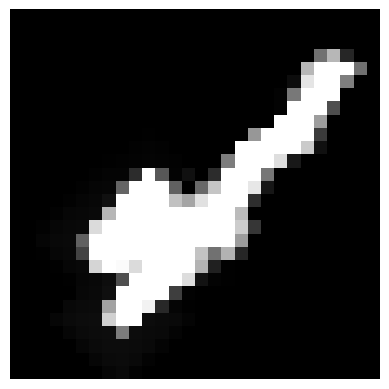

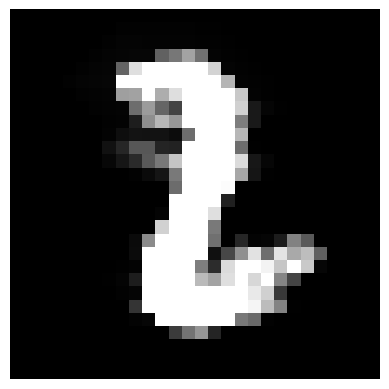

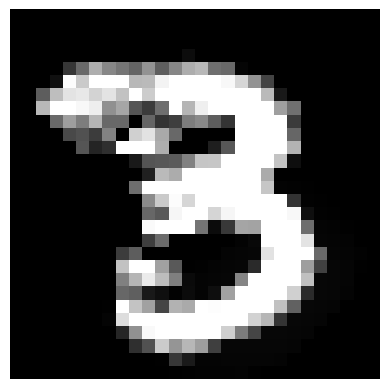

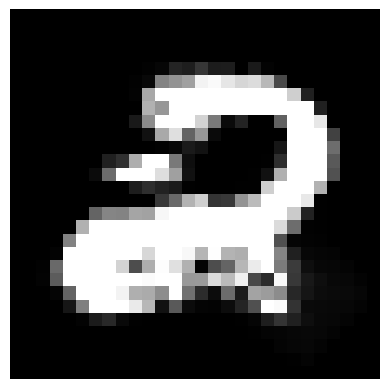

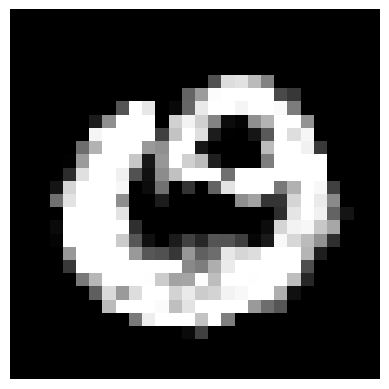

___DONE lambda = 5
lambda = 2


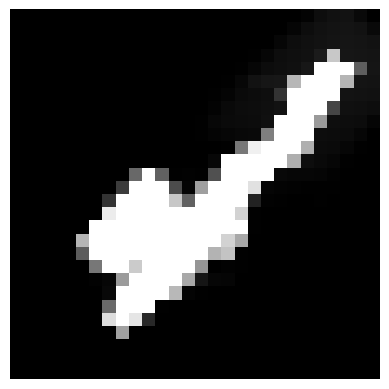

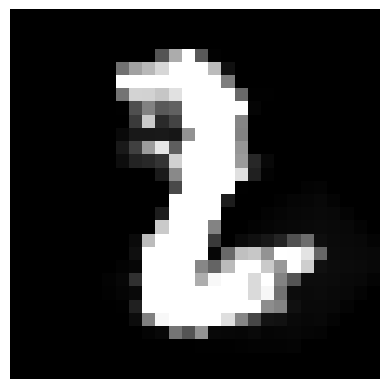

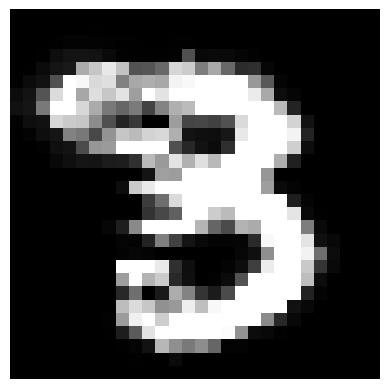

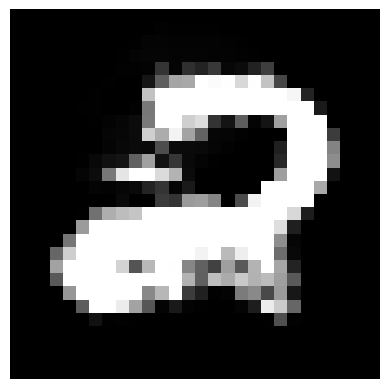

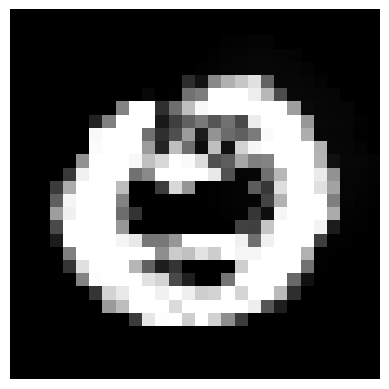

___DONE lambda = 2
lambda = 1


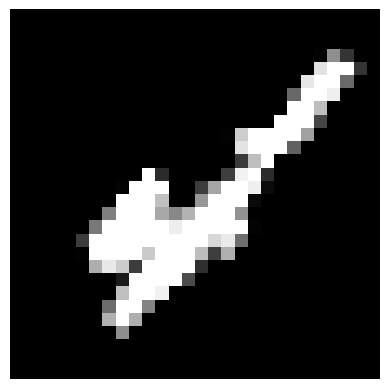

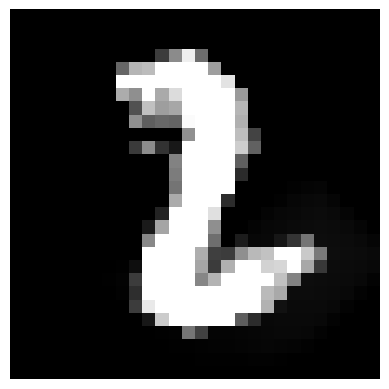

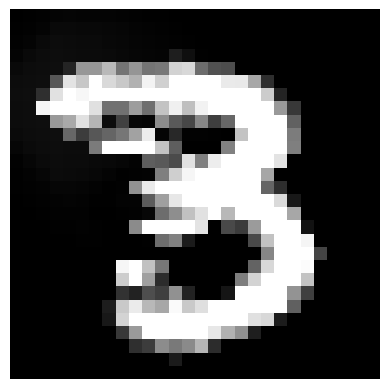

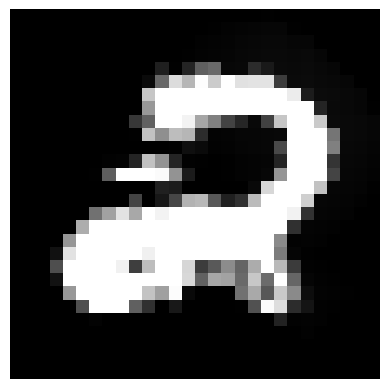

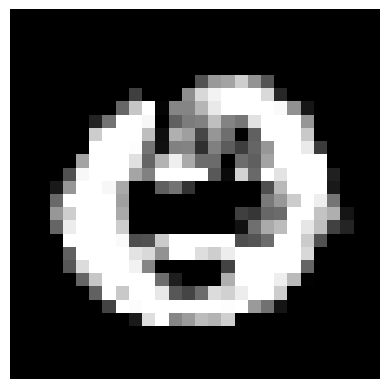

___DONE lambda = 1
lambda = 0.5


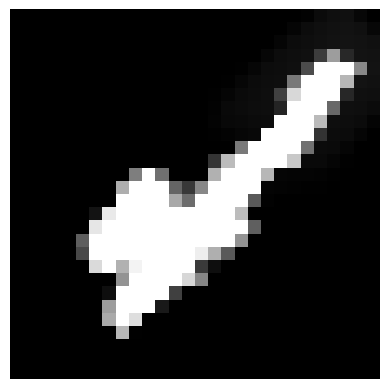

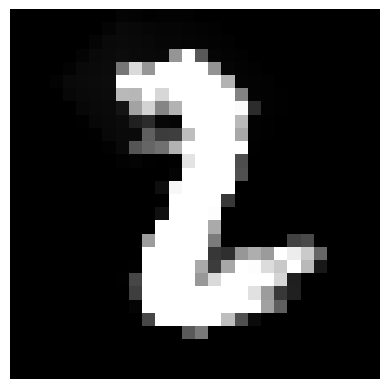

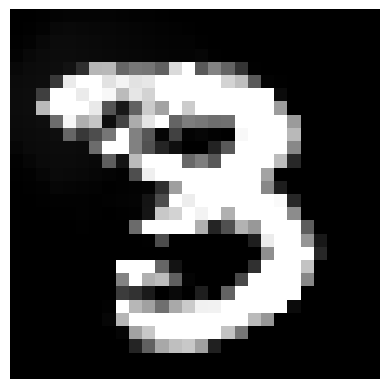

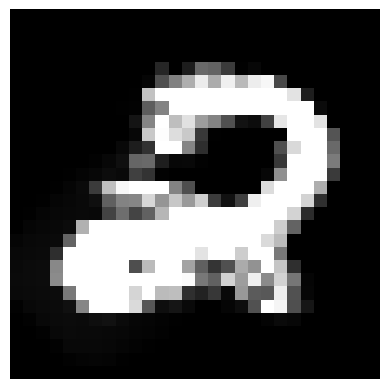

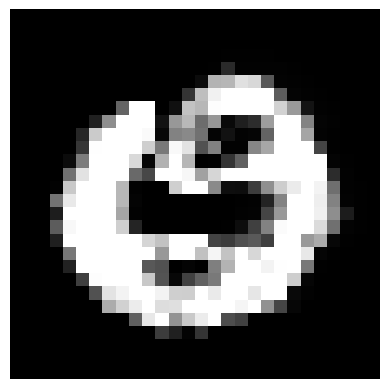

___DONE lambda = 0.5
lambda = 0.2


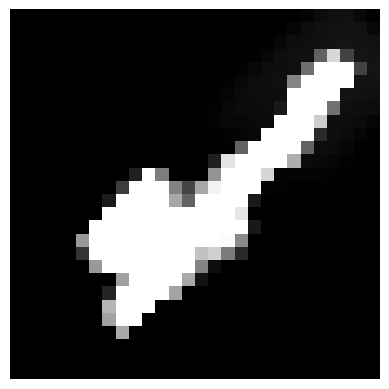

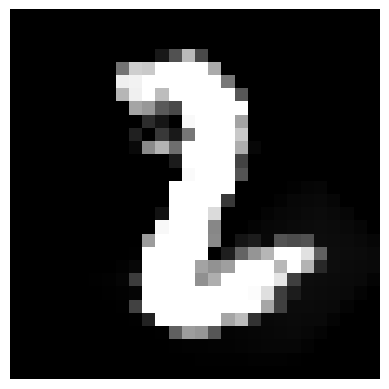

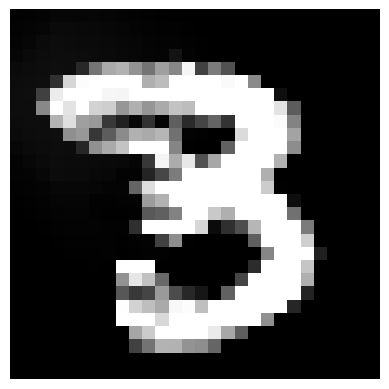

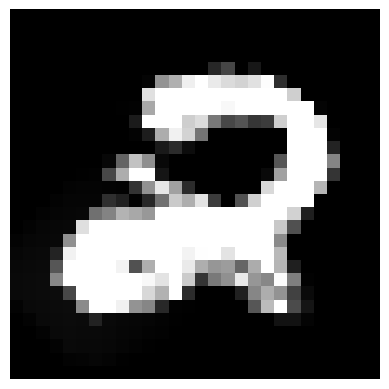

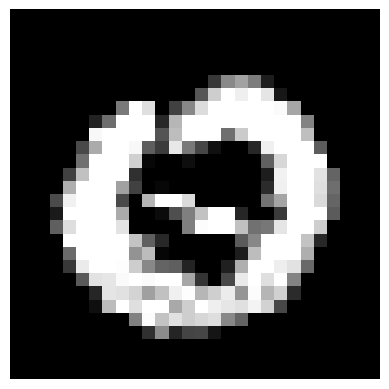

___DONE lambda = 0.2
lambda = 0.1


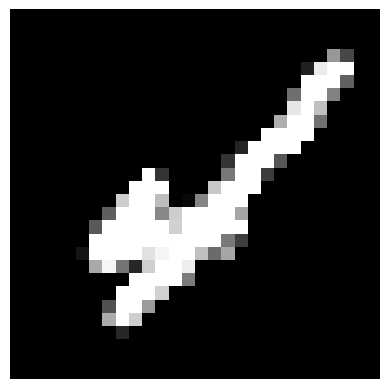

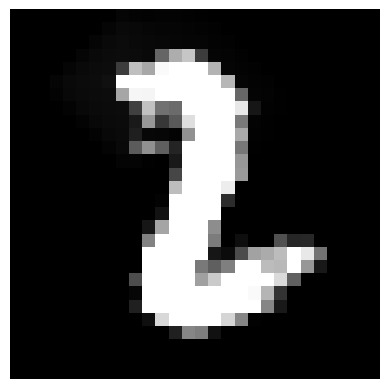

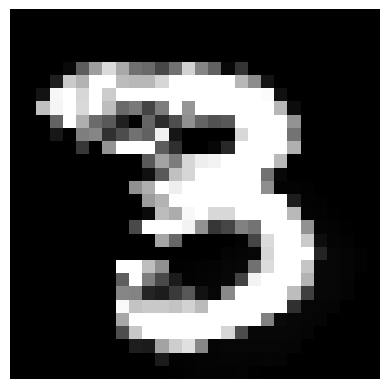

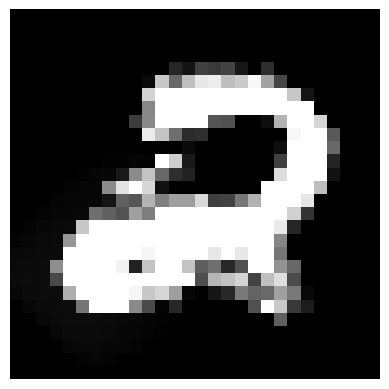

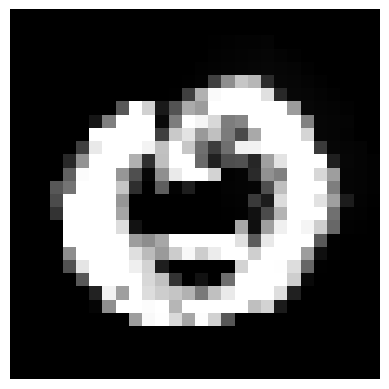

___DONE lambda = 0.1
DONE metric WassersteinApproximation_reg=3_iter=250


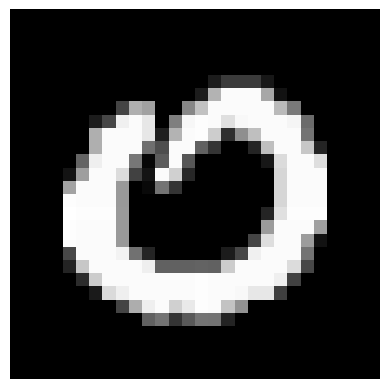

In [11]:
l2 = L2Metric()

for metric in metrics:
    for lambd in lambdas:
        print(f"lambda = {lambd}")
        adv = cw_batch_unsigned(model, benign, labels, lambd, metric['metric'], special_init=False)
        metric['adv'] = adv
        metric['success'] = torch.argmax(model(adv), dim=1) != labels
        metric['dist'] = metric['metric'](benign, adv)
        metric['L2_dist'] = l2(benign, adv)
        for i, example in enumerate(adv):
            ex = example.detach().reshape(28, 28)
            plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
            plt.axis("off")
            if metric['dist'][i] == metric['dist'][i] and (i + 1) % 10 == 0:
                plt.show()
            plt.savefig(
                f"adversarials\\wass_v2\\{metric['name']}_lambda{lambd}_{'adv' if metric['success'][i] else 'ben'}_dist{metric['dist'][i]}_d2{metric['L2_dist'][i]}_{i+1}.png",
                bbox_inches="tight",
                pad_inches=0)
        print(f'___DONE lambda = {lambd}')
    print(f"DONE metric {metric['name']}")

for i, ben in enumerate(benign):
    ex = ben.detach().reshape(28, 28)
    plt.imshow(ex, cmap='gray', vmin=0, vmax=1)
    plt.axis("off")
    plt.savefig(
        f"adversarials\\wass\\benign_{i+1}.png",
        bbox_inches="tight",
        pad_inches=0)

In [12]:
# with open('adversarials\\cw\\results.json', 'w') as f:
#     metrics_to_json = []
#     for metric in metrics:
#         metrics_to_json.append(
#             {
#                 'metric_name': metric['name'],
#                 'success': metric['success'].tolist(),
#                 'dist': metric['dist'].tolist(),
#                 'L2_dist': metric['L2_dist'].tolist(),
#             }
#         )
#     json.dump(metrics_to_json, f)
